In [14]:
import numpy as np
from collections import OrderedDict
import logging
from mlp.layers import AffineLayer
from mlp.errors import CrossEntropySoftmaxError
from mlp.models import MultipleLayerModel
from mlp.initialisers import GlorotUniformInit, ConstantInit
from mlp.learning_rules import MomentumLearningRule
from mlp.data_providers import MNISTDataProvider
from mlp.optimisers import Optimiser

# Seed a random number generator
seed = 24102016 
rng = np.random.RandomState(seed)

num_epochs = 100
stats_interval = 5
batch_size = 50
learning_rate = 0.01
mom_coeff = 0.9
weights_init_gain = 0.5
biases_init = 0.

# Set up a logger object to print info about the training run to stdout
logger = logging.getLogger()
logger.setLevel(logging.INFO)
logger.handlers = [logging.StreamHandler()]

# Create data provider objects for the MNIST data set
train_data = MNISTDataProvider('train', batch_size, rng=rng)
valid_data = MNISTDataProvider('valid', batch_size, rng=rng)
input_dim, output_dim, hidden_dim = 784, 10, 100

weights_init = GlorotUniformInit(weights_init_gain, rng)
biases_init = ConstantInit(biases_init)
error = CrossEntropySoftmaxError()
learning_rule = MomentumLearningRule(learning_rate, mom_coeff)
data_monitors = {'acc': lambda y, t: (y.argmax(-1) == t.argmax(-1)).mean()}

In [18]:
import numpy as np
from mlp.layers import Layer

class TanhLayer(Layer):
    """Layer implementing an element-wise hyperbolic tangent transformation."""

    def fprop(self, inputs):
        """Forward propagates activations through the layer transformation.

        For inputs `x` and outputs `y` this corresponds to `y = tanh(x)`.
        """
        return np.tanh(inputs)

    def bprop(self, inputs, outputs, grads_wrt_outputs):
        """Back propagates gradients through a layer.

        Given gradients with respect to the outputs of the layer calculates the
        gradients with respect to the layer inputs.
        """
        return (1. - outputs**2) * grads_wrt_outputs

    def __repr__(self):
        return 'TanhLayer'
    

class ReluLayer(Layer):
    """Layer implementing an element-wise rectified linear transformation."""

    def fprop(self, inputs):
        """Forward propagates activations through the layer transformation.

        For inputs `x` and outputs `y` this corresponds to `y = max(0, x)`.
        """
        return np.maximum(inputs, 0.)

    def bprop(self, inputs, outputs, grads_wrt_outputs):
        """Back propagates gradients through a layer.

        Given gradients with respect to the outputs of the layer calculates the
        gradients with respect to the layer inputs.
        """
        return (outputs > 0) * grads_wrt_outputs

    def __repr__(self):
        return 'ReluLayer'

In [17]:
from scipy.ndimage.interpolation import rotate

def random_rotation(inputs, rng):
    """Randomly rotates a subset of images in a batch.
    
    Args:
        inputs: Input image batch, an array of shape (batch_size, 784).
        rng: A seeded random number generator.
        
    Returns:
        An array of shape (batch_size, 784) corresponding to a copy
        of the original `inputs` array with the randomly selected
        images rotated by a random angle. The original `inputs`
        array should not be modified.
    """
    orig_ims = inputs.reshape((-1, 28, 28))
    new_ims = orig_ims.copy()
    indices = rng.choice(orig_ims.shape[0], orig_ims.shape[0] // 4, False)
    angles = rng.uniform(-1., 1., size=indices.shape[0]) * 30.
    for i, j in enumerate(indices):
        new_ims[j] = rotate(orig_ims[j], angles[i], order=1, reshape=False)
    return new_ims.reshape((-1, 784))

In [2]:
def random_noise(inputs, rng):
    orig_ims = inputs.reshape((-1, 28, 28))
    new_ims = orig_ims.copy()
    indices = rng.choice(orig_ims.shape[0], orig_ims.shape[0] // 4, False)
    noise = rng.normal(0,1, size=(indices.shape[0],28,28))
    for i, j in enumerate(indices):
        #new_ims[j] = rotate(orig_ims[j], angles[i], order=1, reshape=False)
        new_ims[j] = orig_ims[j] * noise[i]
    return new_ims.reshape((-1, 784))

In [11]:
def random_noise_2(inputs, rng):
    orig_ims = inputs.reshape((-1, 28, 28))
    new_ims = orig_ims.copy()
    indices = rng.choice(orig_ims.shape[0], orig_ims.shape[0] // 4, False)
    noise = rng.normal(0,3, size=(indices.shape[0],28,28))
    for i, j in enumerate(indices):
        #new_ims[j] = rotate(orig_ims[j], angles[i], order=1, reshape=False)
        new_ims[j] = orig_ims[j] * noise[i]
    return new_ims.reshape((-1, 784))

In [4]:
from scipy.ndimage.interpolation import zoom

def random_zoom(inputs, rng):
    orig_ims = inputs.reshape((-1, 28, 28))
    new_ims = orig_ims.copy()
    indices = rng.choice(orig_ims.shape[0], orig_ims.shape[0] // 4, False)
    scale = rng.uniform(0.5,1.5,size=indices.shape[0])
    
    for i, j in enumerate(indices):
        #new_ims[j] = zoom(orig_ims[j],[scale[i], scale[i]],order=0).reshape[-1,28,28]
        if scale[i] < 1:
            r = int(np.round(scale[i] * 28))
            x_scale = (28 - r) // 2
            y_scale = (28 - r) // 2
            out = np.zeros_like(orig_ims[j])
            out[x_scale:x_scale+r, y_scale:y_scale+r] = zoom(orig_ims[j], [scale[i],scale[i]])
            new_ims[j] = out

        else:       
            r = int(np.round(scale[i] * 28))
            x_scale = (r - 28) // 2
            y_scale = (r - 28) // 2
            out = zoom(orig_ims[j][x_scale:x_scale+r, y_scale:y_scale+r],[scale[i],scale[i]])
            trim_top = ((out.shape[0] - 28) // 2)
            trim_left = ((out.shape[1] - 28) // 2)
            out = out[trim_top:trim_top+28, trim_left:trim_left+28]
            new_ims[j] = out
    return new_ims.reshape((-1, 784))

In [12]:
from scipy.ndimage.interpolation import zoom

def random_zoom_2(inputs, rng):
    orig_ims = inputs.reshape((-1, 28, 28))
    new_ims = orig_ims.copy()
    indices = rng.choice(orig_ims.shape[0], orig_ims.shape[0] // 4, False)
    scale = rng.uniform(0.2,2,size=indices.shape[0])
    
    for i, j in enumerate(indices):
        #new_ims[j] = zoom(orig_ims[j],[scale[i], scale[i]],order=0).reshape[-1,28,28]
        if scale[i] < 1:
            r = int(np.round(scale[i] * 28))
            x_scale = (28 - r) // 2
            y_scale = (28 - r) // 2
            out = np.zeros_like(orig_ims[j])
            out[x_scale:x_scale+r, y_scale:y_scale+r] = zoom(orig_ims[j], [scale[i],scale[i]])
            new_ims[j] = out

        else:       
            r = int(np.round(scale[i] * 28))
            x_scale = (r - 28) // 2
            y_scale = (r - 28) // 2
            out = zoom(orig_ims[j][x_scale:x_scale+r, y_scale:y_scale+r],[scale[i],scale[i]])
            trim_top = ((out.shape[0] - 28) // 2)
            trim_left = ((out.shape[1] - 28) // 2)
            out = out[trim_top:trim_top+28, trim_left:trim_left+28]
            new_ims[j] = out
    return new_ims.reshape((-1, 784))

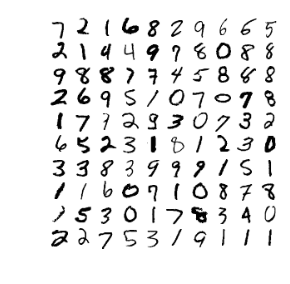

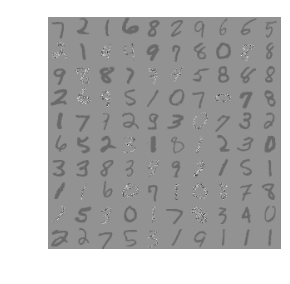

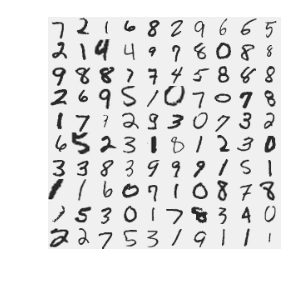

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

def show_batch_of_images(img_batch, name, fig_size=(3, 3)):
    fig = plt.figure(figsize=fig_size)
    batch_size, im_height, im_width = img_batch.shape
    # calculate no. columns per grid row to give square grid
    grid_size = int(batch_size**0.5)
    # intialise empty array to tile image grid into
    tiled = np.empty((im_height * grid_size, 
                      im_width * batch_size // grid_size))
    # iterate over images in batch + indexes within batch
    for i, img in enumerate(img_batch):
        # calculate grid row and column indices
        r, c = i % grid_size, i // grid_size
        tiled[r * im_height:(r + 1) * im_height, 
              c * im_height:(c + 1) * im_height] = img
    ax = fig.add_subplot(111)
    ax.imshow(tiled, cmap='Greys') #, vmin=0., vmax=1.)
    ax.axis('off')
    fig.tight_layout()
    fig.savefig(name+'.png',dpi=200)
    plt.show()
    return fig, ax

test_data = MNISTDataProvider('test', 100, rng=rng)
inputs, targets = test_data.next()
_ = show_batch_of_images(inputs.reshape((-1, 28, 28)),'111')
transformed_inputs = random_noise(inputs, rng)
_ = show_batch_of_images(transformed_inputs.reshape((-1, 28, 28)),'222')
transformed_inputs = random_zoom(inputs, rng)
_ = show_batch_of_images(transformed_inputs.reshape((-1, 28, 28)),'333')

In [15]:
from mlp.data_providers import AugmentedMNISTDataProvider

noise_train_data = AugmentedMNISTDataProvider('train', rng=rng, transformer=random_noise)
zoom_train_data = AugmentedMNISTDataProvider('train', rng=rng, transformer=random_zoom)

In [ ]:
batch_size = 100
num_epochs = 100
learning_rate = 0.01
mom_coeff = 0.9
stats_interval = 5

rng.seed(seed)
aug_train_data.reset()
valid_data.reset()
aug_train_data.batch_size = batch_size 
valid_data.batch_size = batch_size

weights_init = GlorotUniformInit(0.5, rng=rng)
biases_init = ConstantInit(0.)

model = MultipleLayerModel([
    AffineLayer(input_dim, hidden_dim, weights_init, biases_init),
    ReluLayer(),
    AffineLayer(hidden_dim, hidden_dim, weights_init, biases_init),
    ReluLayer(),
    AffineLayer(hidden_dim, output_dim, weights_init, biases_init)
])

error = CrossEntropySoftmaxError()
learning_rule = MomentumLearningRule(learning_rate=learning_rate, mom_coeff=mom_coeff)
data_monitors={'acc': lambda y, t: (y.argmax(-1) == t.argmax(-1)).mean()}
optimiser = Optimiser(
    model, error, learning_rule, aug_train_data, valid_data, data_monitors)
optimiser_ori = Optimiser(
    model, error, learning_rule, train_data, valid_data, data_monitors)

aug_stats, aug_keys, aug_run_time = optimiser.train(
    num_epochs=num_epochs, stats_interval=stats_interval)
aug_stats_ori, aug_keys_ori, aug_run_time_ori = optimiser_ori.train(
    num_epochs=num_epochs, stats_interval=stats_interval)

Dataset: none


Epoch 5: 0.90s to complete
  error(train)=1.16e-01, acc(train)=9.67e-01, error(valid)=1.26e-01, acc(valid)=9.65e-01, params_penalty=0.00e+00
Epoch 10: 0.90s to complete
  error(train)=5.37e-02, acc(train)=9.85e-01, error(valid)=8.77e-02, acc(valid)=9.76e-01, params_penalty=0.00e+00
Epoch 15: 1.34s to complete
  error(train)=3.06e-02, acc(train)=9.92e-01, error(valid)=8.40e-02, acc(valid)=9.76e-01, params_penalty=0.00e+00
Epoch 20: 0.97s to complete
  error(train)=1.88e-02, acc(train)=9.96e-01, error(valid)=8.68e-02, acc(valid)=9.76e-01, params_penalty=0.00e+00
Epoch 25: 0.93s to complete
  error(train)=1.18e-02, acc(train)=9.98e-01, error(valid)=8.67e-02, acc(valid)=9.78e-01, params_penalty=0.00e+00
Epoch 30: 1.01s to complete
  error(train)=5.38e-03, acc(train)=1.00e+00, error(valid)=9.11e-02, acc(valid)=9.77e-01, params_penalty=0.00e+00
Epoch 35: 1.00s to complete
  error(train)=3.49e-03, acc(train)=1.00e+00, error(valid)=9.26e-02, acc(valid)=9.77e-01, params_penalty=0.00e+00
Epoch 4

Dataset: random_noise(0,1)


Epoch 5: 1.63s to complete
  error(train)=6.23e-01, acc(train)=7.89e-01, error(valid)=1.62e-01, acc(valid)=9.53e-01, params_penalty=0.00e+00
Epoch 10: 1.98s to complete
  error(train)=4.00e-01, acc(train)=8.65e-01, error(valid)=1.15e-01, acc(valid)=9.67e-01, params_penalty=0.00e+00
Epoch 15: 1.71s to complete
  error(train)=3.27e-01, acc(train)=8.90e-01, error(valid)=1.09e-01, acc(valid)=9.67e-01, params_penalty=0.00e+00
Epoch 20: 1.67s to complete
  error(train)=2.81e-01, acc(train)=9.08e-01, error(valid)=9.12e-02, acc(valid)=9.74e-01, params_penalty=0.00e+00
Epoch 25: 1.63s to complete
  error(train)=2.60e-01, acc(train)=9.15e-01, error(valid)=9.51e-02, acc(valid)=9.71e-01, params_penalty=0.00e+00
Epoch 30: 1.66s to complete
  error(train)=2.35e-01, acc(train)=9.25e-01, error(valid)=8.86e-02, acc(valid)=9.73e-01, params_penalty=0.00e+00
Epoch 35: 1.64s to complete
  error(train)=2.21e-01, acc(train)=9.29e-01, error(valid)=8.90e-02, acc(valid)=9.72e-01, params_penalty=0.00e+00
Epoch 4

Dataset: random_noise(0,3)


Epoch 5: 1.63s to complete
  error(train)=5.49e-01, acc(train)=8.13e-01, error(valid)=1.70e-01, acc(valid)=9.50e-01, params_penalty=0.00e+00
Epoch 10: 1.66s to complete
  error(train)=3.81e-01, acc(train)=8.74e-01, error(valid)=1.16e-01, acc(valid)=9.68e-01, params_penalty=0.00e+00
Epoch 15: 1.68s to complete
  error(train)=3.28e-01, acc(train)=8.91e-01, error(valid)=1.06e-01, acc(valid)=9.69e-01, params_penalty=0.00e+00
Epoch 20: 1.68s to complete
  error(train)=2.81e-01, acc(train)=9.07e-01, error(valid)=8.77e-02, acc(valid)=9.75e-01, params_penalty=0.00e+00
Epoch 25: 1.71s to complete
  error(train)=2.60e-01, acc(train)=9.13e-01, error(valid)=9.47e-02, acc(valid)=9.74e-01, params_penalty=0.00e+00
Epoch 30: 1.68s to complete
  error(train)=2.35e-01, acc(train)=9.23e-01, error(valid)=8.70e-02, acc(valid)=9.75e-01, params_penalty=0.00e+00
Epoch 35: 1.65s to complete
  error(train)=2.19e-01, acc(train)=9.30e-01, error(valid)=8.82e-02, acc(valid)=9.74e-01, params_penalty=0.00e+00
Epoch 4

Dataset: random_zoom(0.5-1.5)


Epoch 5: 4.22s to complete
  error(train)=1.57e-01, acc(train)=9.54e-01, error(valid)=1.14e-01, acc(valid)=9.67e-01, params_penalty=0.00e+00
Epoch 10: 3.67s to complete
  error(train)=9.59e-02, acc(train)=9.72e-01, error(valid)=8.65e-02, acc(valid)=9.75e-01, params_penalty=0.00e+00
Epoch 15: 3.89s to complete
  error(train)=8.26e-02, acc(train)=9.75e-01, error(valid)=8.53e-02, acc(valid)=9.75e-01, params_penalty=0.00e+00
Epoch 20: 3.71s to complete
  error(train)=5.61e-02, acc(train)=9.84e-01, error(valid)=7.65e-02, acc(valid)=9.77e-01, params_penalty=0.00e+00
Epoch 25: 4.11s to complete
  error(train)=4.95e-02, acc(train)=9.86e-01, error(valid)=7.33e-02, acc(valid)=9.80e-01, params_penalty=0.00e+00
Epoch 30: 4.66s to complete
  error(train)=4.20e-02, acc(train)=9.88e-01, error(valid)=7.53e-02, acc(valid)=9.81e-01, params_penalty=0.00e+00
Epoch 35: 4.46s to complete
  error(train)=3.67e-02, acc(train)=9.89e-01, error(valid)=7.31e-02, acc(valid)=9.81e-01, params_penalty=0.00e+00
Epoch 4

Dataset: random_zoom(0.2-2.0)


Epoch 5: 4.54s to complete
  error(train)=2.58e-01, acc(train)=9.20e-01, error(valid)=1.25e-01, acc(valid)=9.63e-01, params_penalty=0.00e+00
Epoch 10: 3.56s to complete
  error(train)=1.86e-01, acc(train)=9.41e-01, error(valid)=9.33e-02, acc(valid)=9.72e-01, params_penalty=0.00e+00
Epoch 15: 3.56s to complete
  error(train)=1.59e-01, acc(train)=9.49e-01, error(valid)=8.49e-02, acc(valid)=9.76e-01, params_penalty=0.00e+00
Epoch 20: 3.74s to complete
  error(train)=1.32e-01, acc(train)=9.58e-01, error(valid)=8.49e-02, acc(valid)=9.75e-01, params_penalty=0.00e+00
Epoch 25: 3.56s to complete
  error(train)=1.22e-01, acc(train)=9.62e-01, error(valid)=7.76e-02, acc(valid)=9.78e-01, params_penalty=0.00e+00
Epoch 30: 3.54s to complete
  error(train)=1.13e-01, acc(train)=9.63e-01, error(valid)=8.25e-02, acc(valid)=9.78e-01, params_penalty=0.00e+00
Epoch 35: 3.55s to complete
  error(train)=1.00e-01, acc(train)=9.67e-01, error(valid)=7.83e-02, acc(valid)=9.80e-01, params_penalty=0.00e+00
Epoch 4

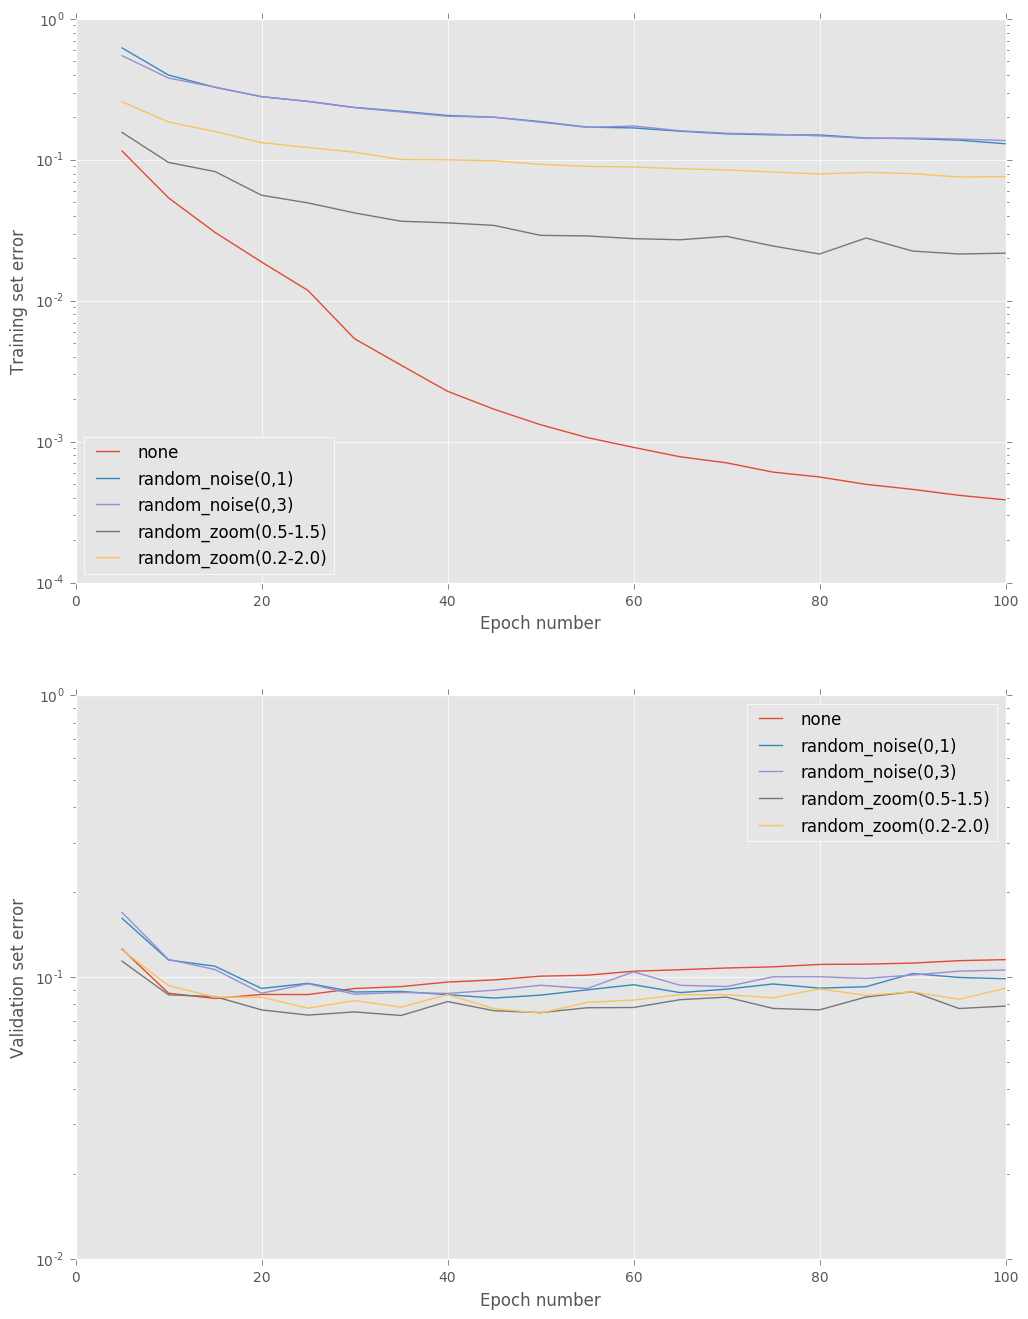

In [19]:
train_datasets = [
    MNISTDataProvider('train', batch_size, rng=rng),
    AugmentedMNISTDataProvider('train', rng=rng, transformer=random_noise),
    AugmentedMNISTDataProvider('train', rng=rng, transformer=random_noise_2),
    AugmentedMNISTDataProvider('train', rng=rng, transformer=random_zoom),
    AugmentedMNISTDataProvider('train', rng=rng, transformer=random_zoom_2)
]

datasets_label = ['none','random_noise(0,1)','random_noise(0,3)','random_zoom(0.5-1.5)','random_zoom(0.2-2.0)']
batch_size = 100
num_epochs = 100
learning_rate = 0.01
mom_coeff = 0.9
stats_interval = 5

run_info = OrderedDict()
models = OrderedDict()
count =0

for dataset in train_datasets:
    rng.seed(seed)
    dataset.reset()
    valid_data.reset()
    dataset.batch_size = batch_size
    valid_data.batch_size = batch_size
    print('Dataset: {0}'.format(datasets_label[count]))
    count += 1
    
    weights_init = GlorotUniformInit(0.5, rng=rng)
    biases_init = ConstantInit(0.)
    model = MultipleLayerModel([
        AffineLayer(input_dim, hidden_dim, weights_init, biases_init),
        ReluLayer(),
        AffineLayer(hidden_dim, hidden_dim, weights_init, biases_init),
        ReluLayer(),
        AffineLayer(hidden_dim, output_dim, weights_init, biases_init)
    ])
    error = CrossEntropySoftmaxError()
    learning_rule = MomentumLearningRule(learning_rate=learning_rate, mom_coeff=mom_coeff)
    data_monitors={'acc': lambda y, t: (y.argmax(-1) == t.argmax(-1)).mean()}
    optimiser = Optimiser(model, error, learning_rule, dataset, valid_data, data_monitors)
    run_info[dataset] = optimiser.train(num_epochs, stats_interval)
    models[dataset] = model

    
    
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

fig = plt.figure(figsize=(12, 16))
ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2)
count = 0
for dataset, run in run_info.items():
    stats, keys, run_time = run
    ax1.plot(np.arange(1, stats.shape[0]) * stats_interval, 
             stats[1:, keys['error(train)']], label=str(datasets_label[count]))
    ax2.plot(np.arange(1, stats.shape[0]) * stats_interval, 
             stats[1:, keys['error(valid)']], label=str(datasets_label[count]))
    count += 1
ax1.legend(loc=0)
ax1.set_xlabel('Epoch number')
ax1.set_ylabel('Training set error')
ax1.set_yscale('log')
ax2.legend(loc=0)
ax2.set_xlabel('Epoch number')
ax2.set_ylabel('Validation set error')
ax2.set_yscale('log')

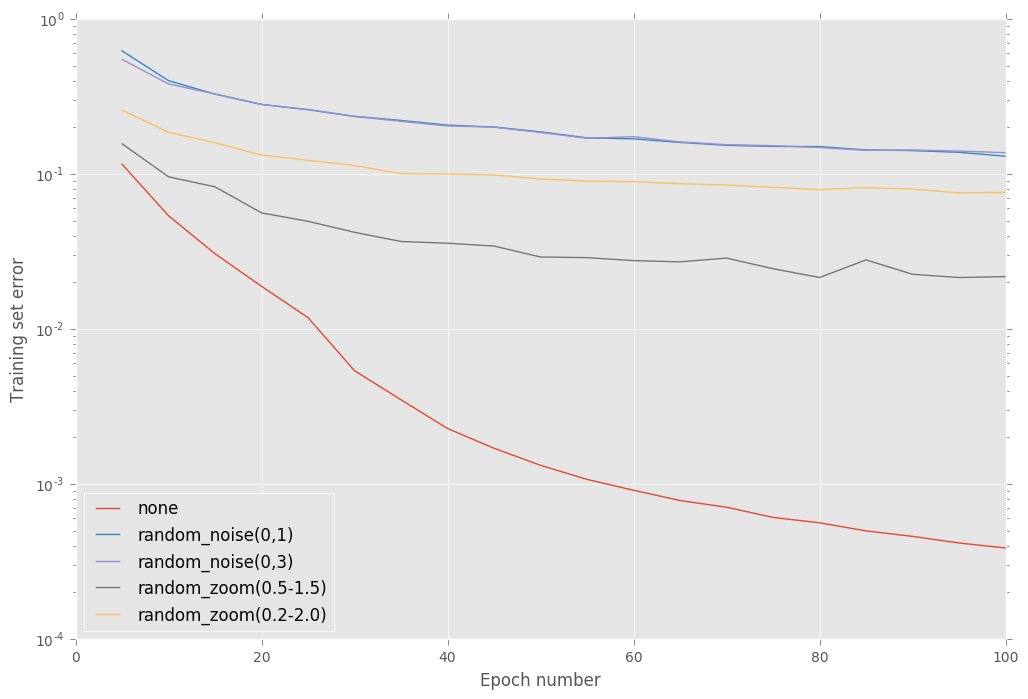

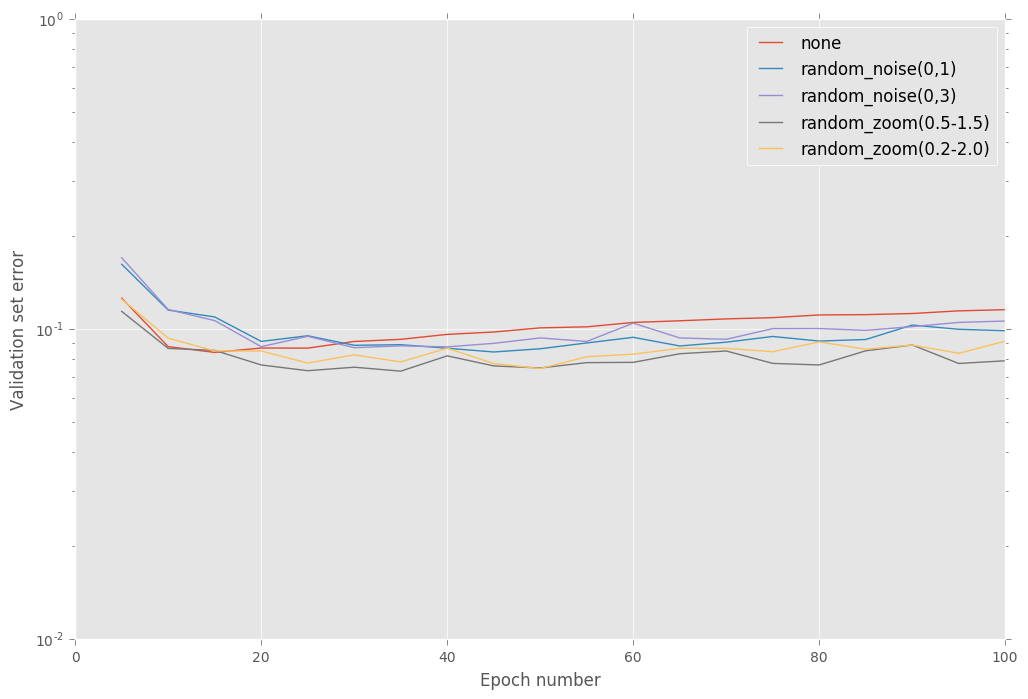

In [20]:
fig_1 = plt.figure(figsize=(12, 8))
fig_2 = plt.figure(figsize=(12, 8))
ax1 = fig_1.add_subplot(1, 1, 1)
ax2 = fig_2.add_subplot(1, 1, 1)
count = 0
for dataset, run in run_info.items():
    stats, keys, run_time = run
    ax1.plot(np.arange(1, stats.shape[0]) * stats_interval, 
             stats[1:, keys['error(train)']], label=str(datasets_label[count]))
    ax2.plot(np.arange(1, stats.shape[0]) * stats_interval, 
             stats[1:, keys['error(valid)']], label=str(datasets_label[count]))
    count += 1
ax1.legend(loc=0)
ax1.set_xlabel('Epoch number')
ax1.set_ylabel('Training set error')
ax1.set_yscale('log')
fig_1.savefig('training_error.png',dpi=200)
ax2.legend(loc=0)
ax2.set_xlabel('Epoch number')
ax2.set_ylabel('Validation set error')
ax2.set_yscale('log')
fig_2.savefig('valid_error.png',dpi=200)